In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import glob
import pickle
import math

from moviepy.editor import VideoFileClip

from IPython.display import display, Markdown

import warnings
warnings.filterwarnings('ignore')

# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
calibration_images = glob.glob('./camera_cal/calibration*.jpg')

image = calibration_images[0]
image = mpimage.imread(image)

image_size = image.shape[1], image.shape[0]

print(len(calibration_images), image_size)

20 (1280, 720)


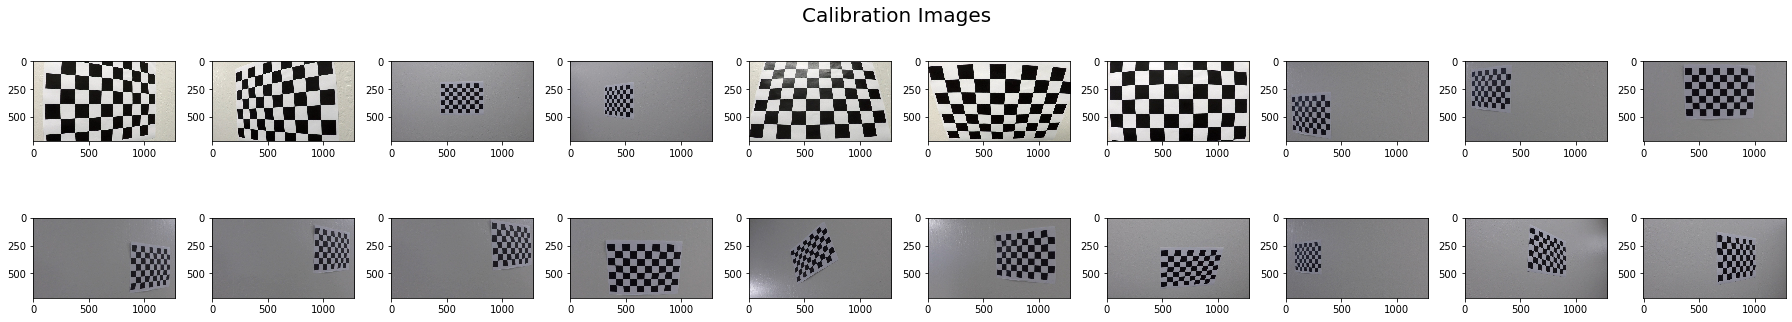

In [3]:
fig, ax = plt.subplots(2, 10, figsize=(25, 5))
ii = 0
for i in range(2):
    for j in range(10):
        img = mpimage.imread(calibration_images[ii])
        ax[i, j].imshow(img)
        ii += 1 
        ax[i, j].set_aspect('equal')
        
fig.suptitle('Calibration Images', fontsize=20)
plt.tight_layout();
plt.savefig('./output_images/calibration.png')

## Object Points and Image Points

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

nx = 9 # Inside corners in x
ny = 6 # Inside corners in y

objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3D Real World
imgpoints = [] # 2D Image Plane

display(Markdown(f'**We will find {nx} object points on x-axis and {ny} object points on y-axis**'))

**We will find 9 object points on x-axis and 6 object points on y-axis**

In [5]:
results = []
for idx, fname in enumerate(calibration_images):
    image = mpimage.imread(fname)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Find Chess Corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)
        image = cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        results.append(image)

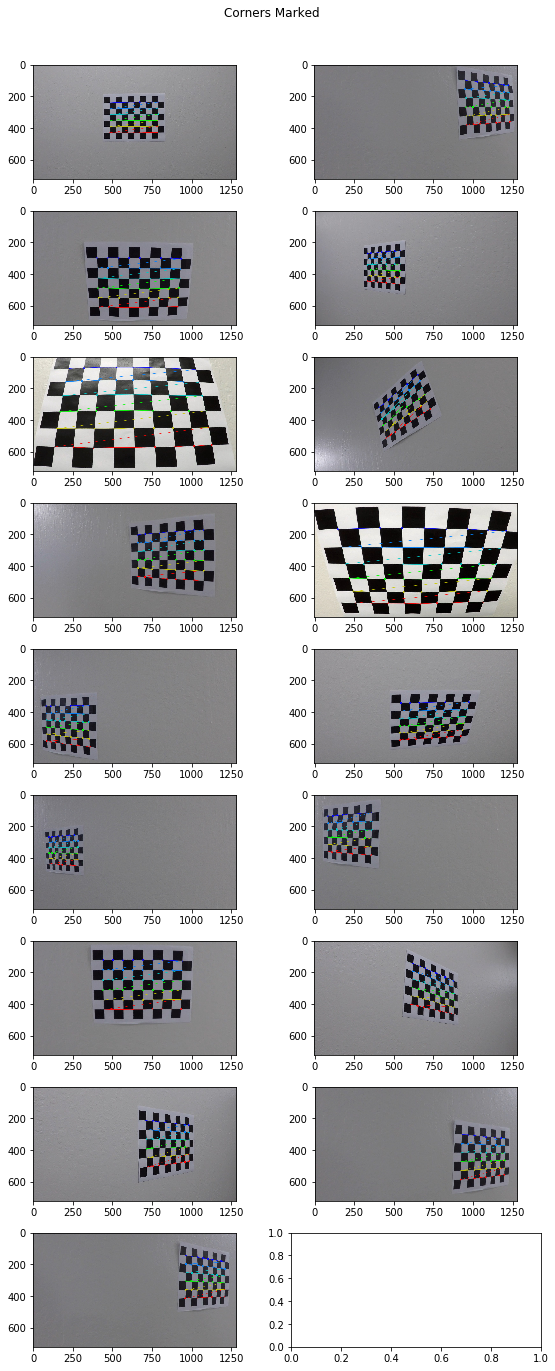

In [6]:
n = len(results)
rows = math.ceil(n/2)

fig, ax = plt.subplots(rows, 2, figsize=(8, 20))
for idx in range(n):
    row = idx % rows
    col = idx % 2
    ax[row, col].imshow(results[idx])

plt.suptitle('Corners Marked')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]);
plt.savefig('./output_images/corners.png')

In [7]:
print(np.array(imgpoints).shape)
print(np.array(objpoints).shape)

print(objpoints[0][0])
print(imgpoints[0][0])

(17, 54, 1, 2)
(17, 54, 3)
[0. 0. 0.]
[[482.64066 241.92659]]


## Calibrate to calculate distortion coefficients, and test undistortion on an image!

In [8]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)

dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist

dist_fname = './data/wide_dist_pickle.p'
pickle.dump(dist_pickle, open(dist_fname, 'wb'))

In [9]:
dist_pickle = pickle.load(open(dist_fname, 'rb'))

mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

## Undistort

In [10]:
def undistort(image):
    image = cv2.undistort(image, mtx, dist, None, mtx)
    return image

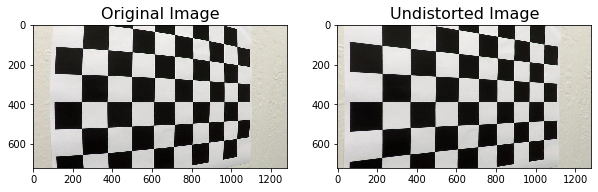

In [11]:
test_image = calibration_images[0]

image = mpimage.imread(test_image)
image_undist = undistort(image)

f, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].imshow(image)
ax[1].imshow(image_undist)
ax[0].set_title('Original Image', fontsize=16)
ax[1].set_title('Undistorted Image', fontsize=16);
plt.savefig('./output_images/undistort_sample.png')

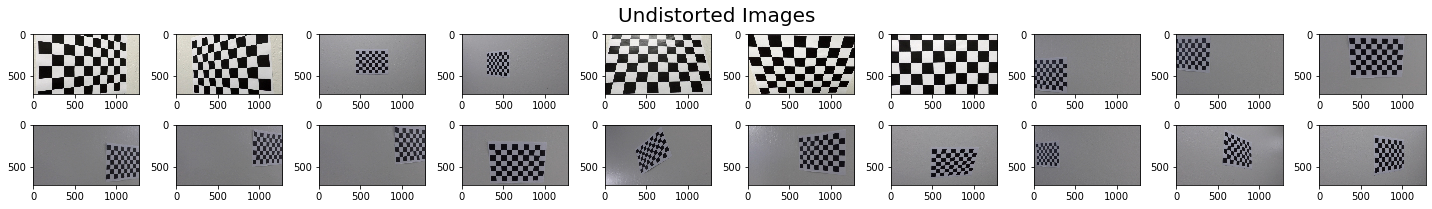

In [12]:
fig, ax = plt.subplots(2, 10, figsize=(20, 3))
for idx in range(20):
    image = undistort(mpimage.imread(calibration_images[idx]))
    row = 0 if idx <=9 else 1 
    col = idx % 10  
    ax[row, col].imshow(image)
plt.suptitle('Undistorted Images', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./output_images/undistort.png')

# Test Images

In [13]:
test_images = glob.glob('./test_images/*.jpg')
image = mpimage.imread(test_images[0])
image_size = (image.shape[1], image.shape[0])
print('test_images: ', len(test_images), image_size)

extra_images = glob.glob('./extra_images/*')
image = mpimage.imread(extra_images[0])
image_size = (image.shape[1], image.shape[0])
print('extra_images: ', len(extra_images), image_size)

test_images:  8 (1280, 720)
extra_images:  1 (1280, 720)


In [ ]:
def warp(image):
    offset = 100
        image_size = image.shape[1::-1]
        
        # For source points I'm grabbing the outer four detected corners
        top_left, top_right = corners[0], corners[nx-1]
        bottom_right, bottom_left = corners[-1], corners[-nx]
        
        src = np.float32([top_left, top_right, bottom_right, bottom_left])
        
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        top_left, top_right = [offset, offset], [image_size[0] - offset, offset]
        bottom_right = [image_size[0] - offset, image_size[1] - offset]
        bottom_left = [offset, image_size[1] - offset]
        
        dst = np.float32([top_left, top_right, bottom_right, bottom_left])
        
        # Perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        
        warped = cv2.warpPerspective(undist, M, image_size)



## Undistort and Transform Perspective

In [ ]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def corners_unwarp(image, nx, ny, mtx, dist):
    
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    #gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret:
        dst = cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100
        image_size = image.shape[1::-1]
        
        # For source points I'm grabbing the outer four detected corners
        top_left, top_right = corners[0], corners[nx-1]
        bottom_right, bottom_left = corners[-1], corners[-nx]
        
        src = np.float32([top_left, top_right, bottom_right, bottom_left])
        
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        top_left, top_right = [offset, offset], [image_size[0] - offset, offset]
        bottom_right = [image_size[0] - offset, image_size[1] - offset]
        bottom_left = [offset, image_size[1] - offset]
        
        dst = np.float32([top_left, top_right, bottom_right, bottom_left])
        
        # Perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        
        warped = cv2.warpPerspective(undist, M, image_size)
        
    return warped, M



In [ ]:
test_image = images[3]
image = mpimage.imread(test_image)

image_size = image.shape[1::-1]


top_down, perspective_M = corners_unwarp(image, nx, ny, mtx, dist)

fig, ax = plt.subplots(1, 2, figsize=(24, 9))

ax[0].imshow(image)
ax[1].imshow(top_down)

ax[0].set_title('Original Image', fontsize=50)
ax[1].set_title('Undistorted and Warped Image', fontsize=50)

fig.tight_layout()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('./output_images/undistort_warp_sample.png')

# Apply a distortion correction to raw images.

In [ ]:


fig, ax = plt.subplots(8, 2, figsize=(10, 15))

for i in range(8):
    image = mpimage.imread(images[i])
    ax[i, 0].imshow(image)
    
    image = undistort(image)
    ax[i, 1].imshow(image, cmap='gray')

    #ax[0, i].set_aspect('equal')
    #ax[1, i].set_aspect('equal')
    
ax[0, 0].set_title('Original', fontsize=20)
ax[0, 1].set_title('Undistorted', fontsize=20)
plt.tight_layout();

plt.savefig('./output_images/undistort_images.png')

# Use color transforms, gradients, etc., to create a thresholded binary image.

## Finding Threshold

In [ ]:
def from_R(image, R_thresh):
    image = undistort(image)
    R = image[:,:,0] 
    R_binary = np.zeros_like(R)
    R_binary[(R >= R_thresh[0]) & (R <= R_thresh[1])] = 1 
    return R_binary

def from_saturation(image, s_thresh):
    image = undistort(image)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

def from_sobelx(image, sx_thresh):
    image = undistort(image)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:, :, 1]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    sobelx_abs = np.absolute(sobelx)
    
    scale_factor = np.max(sobelx_abs) / 255
    scaled_sobel = np.uint8(sobelx_abs/scale_factor)
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)

    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1 

    return sx_binary

In [ ]:
# Special Image screenshot from video

image = './data/extra.png'

image = mpimage.imread(image)

R_thresh = (230, 255)
s_thresh=(150, 255)
sx_thresh=(20, 80)

R_binary = from_R(image, R_thresh)
s_binary = from_saturation(image, s_thresh)
sx_binary = from_sobelx(image, sx_thresh)

fig, ax = plt.subplots(1, 4, figsize=(15, 2))
ax[0].imshow(image)
ax[1].imshow(R_binary, cmap='gray');
ax[2].imshow(s_binary, cmap='gray');
ax[3].imshow(sx_binary, cmap='gray');

fig.suptitle('Special Image screenshot from video', fontsize=16)
plt.savefig('./output_images/special.png')

In [ ]:
images = glob.glob('./test_images/*.jpg')
image = images[1]
image = mpimage.imread(image)

R_thresh = (230, 255)
s_thresh=(150, 255)
sx_thresh=(20, 80)

fig, ax = plt.subplots(8, 4, figsize=(10, 15))

for i in range(8):
    image = mpimage.imread(images[i])
    ax[i, 0].imshow(image)
    
    R_binary = from_R(image, R_thresh)
    ax[i, 1].imshow(R_binary, cmap='gray')
    
    s_binary = from_saturation(image, s_thresh)
    ax[i, 2].imshow(s_binary, cmap='gray')
    
    sx_binary = from_sobelx(image, sx_thresh)
    ax[i, 3].imshow(sx_binary, cmap='gray')
    
ax[0, 0].set_title('Original', fontsize=12)
ax[0, 1].set_title(f'R_binary {R_thresh}', fontsize=12)
ax[0, 2].set_title(f's_binary {s_thresh}', fontsize=12)
ax[0, 3].set_title(f'sx_Binary {sx_thresh}', fontsize=12)

plt.tight_layout();

plt.savefig('./output_images/threshold_binary_images_params.png')

## Pipeline

In [ ]:
def pipeline(image, R_thresh=R_thresh, s_thresh=s_thresh, sx_thresh=sx_thresh):
    
    R_binary = from_R(image, R_thresh)
    s_binary = from_saturation(image, s_thresh)
    sx_binary = from_sobelx(image, sx_thresh)
    
    # Activate binary image when two activated
    combined_binary = np.zeros_like(sx_binary)
    opt1 = (s_binary == 1) & (sx_binary == 1)
    opt2 = (sx_binary == 1) & (R_binary == 1)
    opt3 = (s_binary == 1) & (R_binary == 1)
    opt = opt1 | opt2 | opt3
    
    combined_binary[opt] = 1 

    return combined_binary 
    #return R_binary


In [ ]:
images = glob.glob('./test_images/*.jpg')
print(len(images))

fig, ax = plt.subplots(8, 2, figsize=(10, 15))

for i in range(8):
    image = mpimage.imread(images[i])
    ax[i, 0].imshow(image)
    
    image = pipeline(image)
    ax[i, 1].imshow(image, cmap='gray')
    
ax[0, 0].set_title('Original', fontsize=20)
ax[0, 1].set_title('Thresholded Binary', fontsize=20)

plt.tight_layout();

plt.savefig('./output_images/threshold_binary_images.png')

# Apply a perspective transform to rectify binary image ("birds-eye view").

In [ ]:
#%matplotlib qt 
plt.figure(figsize=(15, 15));

image = mpimage.imread(images[0])

plt.imshow(image);

w, h = image.shape[1], image.shape[0]

plt.plot(595, 450, '*', color='red')
plt.plot(680, 450, '*', color='red')
plt.plot(1210, h, '*', color='red')
plt.plot(200, h, '*', color='red');

plt.title('Original Image with marked Four Selected Object Points', fontsize=20);

plt.savefig('./output_images/sample_corners.png')

In [ ]:
def birds_eye(image):

    binary_img = pipeline(image)
    
    w, h = binary_img.shape[1], binary_img.shape[0]
    image_size = (w, h) #binary_img.shape[1::-1]
    
    # For source points - grabbing ROI
    top_left = [595, 450] 
    top_right = [685, 450]
    bottom_right = [1210, h]
    bottom_left = [200, h]
    
    src = np.float32([top_left, top_right, bottom_right, bottom_left])
    
    # Destination points
    offset = 300
    
    top_left = [offset, 0]
    top_right = [w - offset, 0]
    bottom_right = [w - offset, h]
    bottom_left = [offset, h]
    
    dst = np.float32([top_left, top_right, bottom_right, bottom_left])
    
    # Perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
        
    warped = cv2.warpPerspective(binary_img, M, image_size, flags=cv2.INTER_LINEAR)
        
    return warped, M

In [ ]:
%matplotlib inline 
images = glob.glob('./test_images/*.jpg')
print(len(images))

fig, ax = plt.subplots(8, 2, figsize=(10, 15))

for i in range(8):
    image = mpimage.imread(images[i])
    ax[i, 0].imshow(image)
    
    image, M = birds_eye(image)
    
    ax[i, 1].imshow(image, cmap='gray')
    
ax[0, 0].set_title('Original', fontsize=20)
ax[0, 1].set_title('Warped (Bird-Eye)', fontsize=20)

plt.tight_layout();

plt.savefig('./output_images/bird_eye_images.png');

# Detect lane pixels and fit to find the lane boundary

## Sliding Window - Finding Lane

In [ ]:
images = glob.glob('./test_images/*.jpg')
image = images[0]
image = mpimage.imread(image)

binary_warped, M = birds_eye(image)

def find_lane_pixels(binary_warped):
    
    # histogram
    h, w = binary_warped.shape[0], binary_warped.shape[1]
    
    half_image = binary_warped[h//2:, :]
    
    histogram = np.sum(half_image, axis=0)
    
    # out image
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255 
    
    # histogram peaks and left/right lanes
    mid = histogram.shape[0] // 2
    leftx_base = np.argmax(histogram[:mid])
    rightx_base = np.argmax(histogram[mid:]) + mid
        
    # Hyperparameters
    nwindows = 15  
    margin = 150   
    minpix = 50 
    window_height = h // nwindows
    
    # x and y positions of all nonzero pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
        
    # Current Positions to be updated
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y
        
        win_y_high = h - window * window_height
        win_y_low = h - (window + 1) * window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
                
        
        # Draw the windows on the visualization image
        pt1 = (win_xleft_low, win_y_low)
        pt2 = (win_xleft_high, win_y_high)
        color = (0, 255, 0)
        thickness = 2
        cv2.rectangle(out_img, pt1, pt2, color, thickness)
        
        pt1 = (win_xright_low, win_y_low)
        pt2 = (win_xright_high, win_y_high)
        cv2.rectangle(out_img, pt1, pt2, color, thickness)

        
        # Identify the nonzero pixels in x and y within the window
        left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                    (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high))
        good_left_inds = left_inds.nonzero()[0]

        right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                    (nonzerox >= win_xright_low) & (nonzerox < win_xright_high))
        good_right_inds = right_inds.nonzero()[0]
                
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            inds = nonzerox[good_left_inds]
            leftx_current = np.int(np.mean(inds))
            
        if len(good_right_inds) > minpix:
            inds = nonzerox[good_right_inds]
            rightx_current = np.int(np.mean(inds))
       
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
   
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
   
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img
    
plt.imshow(binary_warped, cmap='gray');

## Fit Polynomial

In [ ]:
def fit_polynomial(binary_warped):
    
    h, w = binary_warped.shape[0], binary_warped.shape[1]
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, h-1, h)
    
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, left_fit, right_fit 

In [ ]:
out_img, left_fit, right_fit = fit_polynomial(binary_warped)
plt.imshow(out_img);

plt.title('Lane Finding using Sliding Window', fontsize=20)
plt.savefig('./output_images/sliding_sample.png')

## Skip the sliding windows

In [ ]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    h, w = img_shape[0], img_shape[1]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, h-1, h)
    
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2] 
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit, disp_fit=True):
    margin = 50
    
    # Grab Activate Pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    xvals = left_fit[0] * nonzeroy**2 + left_fit[1] * nonzeroy + left_fit[2]
    left_lane_inds = (nonzerox > xvals - margin) & (nonzerox < xvals + margin)

    xvals = right_fit[0] * nonzeroy**2 + right_fit[1] * nonzeroy + right_fit[2]
    right_lane_inds = (nonzerox > xvals - margin) & (nonzerox < xvals + margin)
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
                    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    

    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials # try
    if len(leftx) != 0 and len(rightx) != 0:
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    
    # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
        window_img = np.zeros_like(out_img)
    
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
        
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
        # Plot the polynomial lines onto the image
        if disp_fit and (len(leftx) != 0 and len(rightx) != 0):
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##

        return result, left_fitx, right_fitx, ploty
    else:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        left_fitx, right_fitx, ploty = [], [], []
        
        return result, left_fitx, right_fitx, ploty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
images = glob.glob('./test_images/*.jpg')
image = images[0]
image = mpimage.imread(image)

binary_warped, _ = birds_eye(image)

# out_img, left_fit, right_fit = fit_polynomial(binary_warped)

result, left_fitx, right_fitx, ploty = search_around_poly(binary_warped, left_fit, right_fit)

# View your output
plt.imshow(result);

plt.title('Sample Lane', fontsize=20)
plt.savefig('./output_images/sample_lane.png')

## Lane Finding

In [ ]:
%matplotlib inline 
images = glob.glob('./test_images/*.jpg')
print(len(images))

fig, ax = plt.subplots(8, 2, figsize=(10, 15))

for i in range(8):
    image = mpimage.imread(images[i])
    ax[i, 0].imshow(image)
    
    binary_warped, _ = birds_eye(image)
    
    image, left_fitx, right_fitx, ploty = search_around_poly(binary_warped, left_fit, right_fit)

    ax[i, 1].imshow(image)

ax[0, 0].set_title('Original', fontsize=20)
ax[0, 1].set_title('Lane in Bird-Eye View', fontsize=20)

plt.savefig('./output_images/lane_images.png')
plt.tight_layout();

# Measure Curvature

In [ ]:
def measure_curvature_pixels(left_fitx, right_fitx, ploty):
    
    left_fit = np.polyfit(ploty, left_fitx, 2)
    right_fit = np.polyfit(ploty, right_fitx, 2)
    
    y_eval = np.max(ploty)
        
    A, B, C = left_fit[0], left_fit[1], left_fit[2]
    
    left_curverad = (((1 + (2 * A * y_eval + B)**2))**1.5) / np.absolute(2*A)

    A, B, C = right_fit[0], right_fit[1], right_fit[2]
    right_curverad = (((1 + (2 * A * y_eval + B)**2))**1.5) / np.absolute(2*A)
        
    return left_curverad, right_curverad


def measure_curvature_real(left_fitx, right_fitx, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fitx = [lx * xm_per_pix for lx in left_fitx]
    right_fitx = [rx * xm_per_pix for rx in right_fitx]
    
    ploty = [py * ym_per_pix for py in ploty]
    
    left_fit = np.polyfit(ploty, left_fitx, 2)
    right_fit = np.polyfit(ploty, right_fitx, 2)

    y_eval = np.max(ploty)
    
    
    A, B, C = left_fit[0], left_fit[1], left_fit[2]
    
    y_eval = y_eval * ym_per_pix 
    
    left_curverad = (((1 + (2 * A * y_eval + B)**2))**1.5) / np.absolute(2*A)
    
    A, B, C = right_fit[0], right_fit[1], right_fit[2]
    
    right_curverad = (((1 + (2 * A * y_eval + B)**2))**1.5) / np.absolute(2*A)
    
    avg_curvature = (left_curverad + right_curverad)//2 
        
    return avg_curvature

def get_centre(left_fitx, right_fitx, ploty, image=image):
    
    left_fitx = left_fitx[-20:]
    right_fitx = right_fitx[-20:] 

    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    diff = [l + (r - l)/2 for r, l in zip(right_fitx, left_fitx)]
    vehicle_pos = np.mean(diff)

    h, w = image.shape[0], image.shape[1]
    
    centre_image = w // 2 
    
    offset = centre_image - vehicle_pos
    offset = offset * xm_per_pix
    offset = round(offset, 2)
    
    if offset > 0:
        msg = f'Vehicle is {np.absolute(offset)}m left of center'
    if offset < 0:
        msg = f'Vehicle is {np.absolute(offset)}m right of center'
    if offset == 0:
        msg = f'Vehicle is {np.absolute(offset)}m at center'
    
    return offset, msg

images = glob.glob('./test_images/*.jpg')
image = images[0]
image = mpimage.imread(image)
binary_warped, M = birds_eye(image) 

out_image, left_fitx, right_fitx, ploty = search_around_poly(binary_warped, left_fit, right_fit, disp_fit=False)

#left_curverad, right_curverad = measure_curvature_pixels(left_fitx, right_fitx, ploty)

avg_curvature = measure_curvature_real(left_fitx, right_fitx, ploty)

cx, msg2 = get_centre(left_fitx, right_fitx, ploty)

msg1 = f'Radius of Curvature = {avg_curvature}(m)'


font = cv2.FONT_HERSHEY_SIMPLEX

if len(left_fitx) != 0 and len(right_fitx) != 0:
    cv2.putText(out_image, msg1, (50, 50), font, 1.2, (255,255,255), 5)
    cv2.putText(out_image, msg2, (50, 100), font, 1.2, (255,255,255), 5)

    #wid = 50
    #cv2.line(out_image, (cx-wid, cy-50), (cx+wid, cy-50), (255,0,0), 4 )

print(msg1)
print(msg2)

plt.title('sample output in bird eye view', fontsize=20)
plt.imshow(out_image);

plt.savefig('./output_images/sample_output_bird_eye.png');

In [ ]:
binary_warped, M = birds_eye(image) 

Minv = np.linalg.inv(M)
w, h = image.shape[1], image.shape[0]
    
out_image, left_fitx, right_fitx, ploty = search_around_poly(binary_warped, left_fit, right_fit, disp_fit=False)
    
for x1, x2, y1 in zip(left_fitx, right_fitx, ploty):
    x1, x2, y1 = int(x1), int(x2), int(y1)
    y2 = y1
    cv2.line(out_image, (x1, y1), (x2, y2), (0,255,0), 2)

out_image = cv2.warpPerspective(out_image, Minv, (w, h))
    
result = cv2.addWeighted(image, 1, out_image, 0.3, 0)


plt.imshow(result);

In [ ]:
def process_image(image):
    
    binary_warped, M = birds_eye(image) 

    Minv = np.linalg.inv(M)
    w, h = image.shape[1], image.shape[0]
    
    out_image, left_fitx, right_fitx, ploty = search_around_poly(binary_warped, left_fit, right_fit, disp_fit=False)
    
    for x1, x2, y1 in zip(left_fitx, right_fitx, ploty):
        x1, x2, y1 = int(x1), int(x2), int(y1)
        y2 = y1
        cv2.line(out_image, (x1, y1), (x2, y2), (0,255,0), 2)
    
    out_image = cv2.warpPerspective(out_image, Minv, (w, h))
    
    result = cv2.addWeighted(image, 1, out_image, 0.3, 0)
    
    if len(left_fitx) != 0 and len(left_fitx) != 0:
        
        avg_curvature = measure_curvature_real(left_fitx, right_fitx, ploty)
            
        cx, msg2 = get_centre(left_fitx, right_fitx, ploty)

        msg1 = f'Radius of Curvature = {avg_curvature}(m)'
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        cv2.putText(result, msg1, (50,50), font, 1.2, (255,255,255), 5)
        cv2.putText(result, msg2, (50, 100), font, 1.2, (255,255,255), 5)
        
        #wid = 50
        #cv2.line(result, (cx-wid, cy-50), (cx+wid, cy-50), (255,255,255), 4 )
        
    return result

images = glob.glob('./test_images/*.jpg')
image = images[0]
image = mpimage.imread(image)
image = process_image(image)

plt.title('Sample Output', fontsize=20)

plt.imshow(image);

plt.savefig('./output_images/sample_output.png')

In [ ]:
vid_output = './data/project_video_marked.mp4'

clip = VideoFileClip('./data/project_video.mp4')

#clip_marked = clip.fl_image(lambda image: process_image(image))

#clip_marked.write_videofile(vid_output, audio=False)
